<a href="https://colab.research.google.com/github/cb-314/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic assumtions and simplifications

* assumptions towards the target
  * given the variables of the task I'm assuming that it's a regression task and not a good/bad product classification task
  * however, from a business perspective it might be more relevant to classify hits and flops
* preprocessing
  * To make my life easier I will remove everything but [a-zA-Z] and whitespaces, which is very restrictive
  * I will do the same preprocessing for test and train as I don't use the target for preprocessing. In general this is not advisable, but for experimentation purposes I'm taking the risk of informations leaks, which seems low from what I am doing.
* nlp specifics
  * I'm using word2vec as the task wanted some nice clustering visualization, which usually looks nice for word2vec
  * I'm also using a word embedding model and a regression model seperately, which should both be assessed for performance.
  * I jumped straight to word2vec instead of trying bag-of-words, tf/idf or doc2vec, because I don't have a good intuition, which might work better for this case and I didn't want to spend the time to try them out as it would have added a lot of dimensions to tuning. So for now this is clamped.
* models
  * For now I will ignore the order of words in text and description as I have limited time
  * I'm not going to attempt to use a Transformer for this task as it would take too much time and ressources
  * I will asses performance only on english items as per my preprocessing, else calculating metrics gets annonying
* general
  * this is more a data story and not some software engineering project at this stage, so I'm not using a proper pipeline and so on yet in order to be able to easily check intermediate stages and change things

# setting everything up

## install requirements

As I am using Google Colab, I can't easily check out requirements.txt from github. Also their standard environment already includes everything I need, so I didn't have to install anything. Nevertheless, the requirements.txt is included on github as required and is generated from the Google Colab environment, so it has a lot of stuff I don't actually need. Cleaning this up would be annoying.

I'm only using:
* pandas
* numpy
* sklearn
* nltk
* gensim
* matplotlib
* seaborn

In [1]:
#!pip3 freeze > /content/drive/MyDrive/requirements.txt

In [2]:
#!pip install -r requirements.txt

## libraries, constants, etc.

In [3]:
from google.colab import drive

import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold
import sklearn.linear_model
import sklearn.ensemble

from sklearn.experimental import enable_hist_gradient_boosting
import sklearn.ensemble

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import nltk
import gensim

In [4]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## key collection
I use different lists of (primary) keys in different parts of this task.

In [5]:
# primary keys from raw data
raw_primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [6]:
# use these keys to normalize
primary_keys = raw_primary_keys + ["split"]
text_keys = primary_keys + ["source"]

In [7]:
# keys for everything word2vec related
doc_keys = primary_keys + ["order_count"]

## read data


In [8]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# read parquet file
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# sanity checks of the raw data

## check primary keys

In [10]:
print("all", ":", len(products_all_raw_df))
for i in np.arange(len(raw_primary_keys)):
  curr_cols = raw_primary_keys[:i+1]
  print(curr_cols, ":", len(products_all_raw_df[curr_cols].drop_duplicates()))

all : 633148
['product_id'] : 633148
['product_id', 'vendor_id'] : 633148
['product_id', 'vendor_id', 'vendor_geohash'] : 633148


Nice, these are all unique and we are not being fooled!

## look at target

In [11]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

In [12]:
products_all_raw_df.nlargest(20, "order_count")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
3845,3845,903,w21zs0h,2pc Chickenjoy VM,"2pc Chickenjoy, 1 Side, 1 Drink, 1 Gravy",1386
18078,18078,19,w23b4j4,Chew's Fresh Brown Eggs with Vitamin E 10s x 60g,,1358
21402,21402,19,w23b4j4,Chew's Corn and Soya Fresh Brown Eggs with Vit...,,1277
45838,45838,1421,w21zwre,Chicken Coney Dog with Beef Sauce Combo,"1 Chicken Coney Dog with Beef Sauce, 1 Reg Cur...",1206
3739,3739,36,w21zey6,Anchor Strong Pilsner Beer Can 490ml,With its long standing European heritage and b...,1196
36414,36414,106,w21z6cf,Fresh Banana 5s,Country of Origin: Philippines,1037
22908,22908,1760,w21zg1k,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",996
51321,51321,1421,w21zwre,Mozza Burger® Combo,"1 Mozza Burger® , 1 Reg Curly Fries & 1 Reg A&...",978
44013,44013,1421,w21zwre,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",961
2976,2976,1421,w21zwre,Double Cheeseburger Combo,"1 Double Cheeseburger, 1 Reg Curly Fries & 1 R...",955


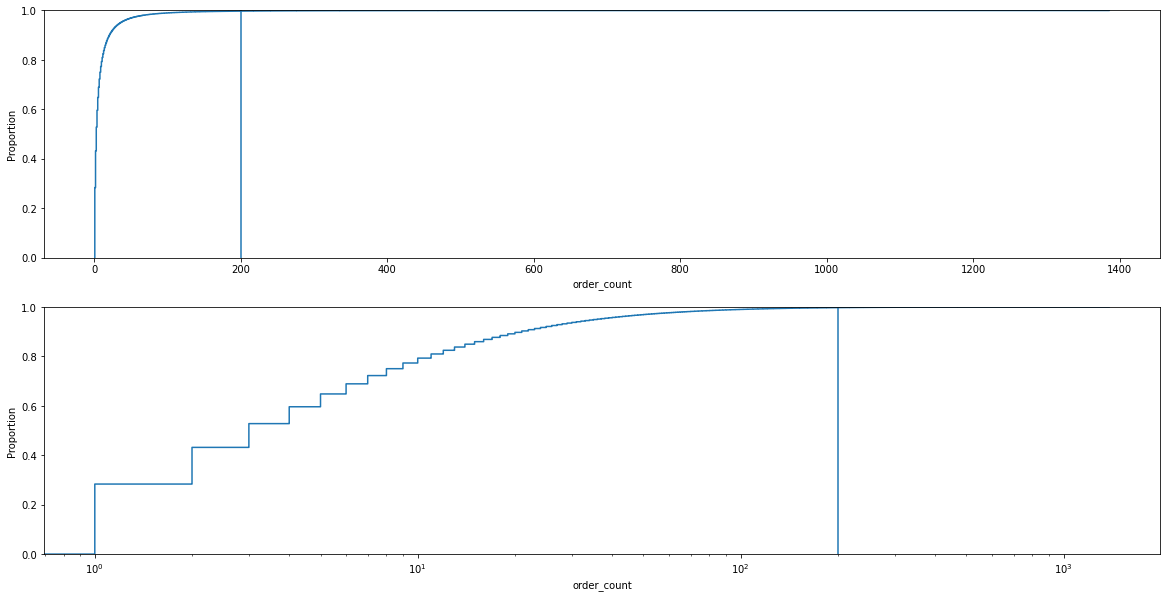

In [13]:
# plot the order count ecdf
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[0]
)
ax[0].axvline(200)
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[1]
)
ax[1].set_xscale("log")
ax[1].axvline(200)
fig.show()

That is a target distribution I don't really want to see. Most orders are less than five and only a few orders have a significant number. One needs to sample from more than just one month to make useful predictions.

As an idea: I could apply some transform to order_count, probably log and then clip at 200. But this has to be taken into account when calculating MSE/MAE and so on. I will also have to check if that is worthwhile. Doing this is also a (very minimal) information leak.

# data cleanup

## train test split
For simplicity, I will do the same preprocessing to test and train, which is usually something you have to be really careful doing. However, I'm doing it here for simplicity and because none of the preprocessing steps is using the target.

In [14]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

While developing some parts of this, I used a reduced sample of my data to speed up the process.

In [15]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)
products_sample_raw_train_df = products_sample_raw_train_df.copy()
products_sample_raw_test_df = products_sample_raw_test_df.copy()
products_sample_raw_train_df["split"] = "train"
products_sample_raw_test_df["split"] = "test"

# put it together for ease of preprocessing
products_sample_raw_train_test_df = pd.concat([products_sample_raw_train_df, products_sample_raw_test_df])
products_sample_raw_train_test_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
568019,568019,492,w21ze1d,Curry Chicken with Rice + Mee Rebus,None,11,train
124596,124596,5689,w21z7k8,Sausage McMuffin® Meal,Just the simple taste of savoury chicken sausa...,1,train
75358,75358,912,w23b1s5,Breakfast Hotcakes (2pc) Happy Meal®,Treat your little ones to flavoursome fun-size...,1,train
153616,153616,282,w21z6dh,Iced Milo®,None,1,train
96778,96778,10818,w21z6tr,Soft-shell Crab Tacos,"Soft-shell Crab, Chilli Mayo, Tobiko and Seawe...",1,train
...,...,...,...,...,...,...,...
142444,142444,6717,w21ze19,NongShim Shin Ramyun Gourmet Spicy Noodle | 12...,None,1,test
330872,330872,5674,w23b4eg,Sausage McMuffin®,Just the simple taste of savoury chicken sausa...,2,test
611347,611347,2025,w21z7zt,Brinjal 烤茄子,None,17,test
486287,486287,5914,w21z7qy,BR2. Tomato Baked Rice,None,6,test


## data normalization
I want to normalize the data into `product`, `product_name` and `product_description` and then stack name and description to use the same preprocessing on both to make my life easier.

In [16]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_test_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

In [17]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [18]:
# put it together for ease of preprocessing
products_name_df["source"] = "name"
products_description_df["source"] = "description"
products_text_df = pd.concat([products_name_df, products_description_df])

In [19]:
# the stacked result
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
568019,568019,492,w21ze1d,train,Curry Chicken with Rice + Mee Rebus,name
124596,124596,5689,w21z7k8,train,Sausage McMuffin® Meal,name
75358,75358,912,w23b1s5,train,Breakfast Hotcakes (2pc) Happy Meal®,name
153616,153616,282,w21z6dh,train,Iced Milo®,name
96778,96778,10818,w21z6tr,train,Soft-shell Crab Tacos,name
...,...,...,...,...,...,...
142444,142444,6717,w21ze19,test,None,description
330872,330872,5674,w23b4eg,test,Just the simple taste of savoury chicken sausa...,description
611347,611347,2025,w21z7zt,test,None,description
486287,486287,5914,w21z7qy,test,None,description


## basic cleanup

Here I reduce all text to only `[a-zA-Z]` and whitespaces. In the end I will also convert everything to lower to better interface with NLTK etc.

In [20]:
# drop empty text
products_text_df.dropna(inplace=True)

# replace everything but basic chars for now
products_text_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)

# remove single and double characters
products_text_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)

# remove all consecutive whitespaces
products_text_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_text_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_text_df = products_text_df[products_text_df["text"] != ""]

In [21]:
# sanity check
"".join(sorted(set("".join(["".join(set(x)) for x in products_text_df["text"].tolist()]))))

' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [22]:
# we are still dealing with slices, so copy to be safe
products_text_df = products_text_df.copy()

# to lower
products_text_df["text"] = products_text_df["text"].str.lower()

In [23]:
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
568019,568019,492,w21ze1d,train,curry chicken with rice mee rebus,name
124596,124596,5689,w21z7k8,train,sausage mcmuffin meal,name
75358,75358,912,w23b1s5,train,breakfast hotcakes pc happy meal,name
153616,153616,282,w21z6dh,train,iced milo,name
96778,96778,10818,w21z6tr,train,soft shell crab tacos,name
...,...,...,...,...,...,...
155661,155661,3953,w21zc5n,test,sweet raspberry and bold black currant gets to...,description
27714,27714,36,w21zey6,test,baron strong brew is brewed in the classic eur...,description
444395,444395,2691,w21z7hu,test,for serious fish lovers that two white fish fi...,description
245699,245699,912,w23b1s5,test,spicy iconic favourite made for singapore since,description


## tokenization and stemming

Leverage NLTK to do tokenization and stemming. I'm using a Snowball stemmer here. Furthermore, I'm also pivoting the text to long format keeping and index to keep track of the order of words (eventhough I don't plan to use it for anything).

In [24]:
products_text_token_df = products_text_df.copy()

In [25]:
# tokenization
products_text_token_df["text_tokens"] = products_text_token_df["text"].transform(nltk.word_tokenize)

In [26]:
# add a position index and explode
products_text_token_df["idx"] = 1
products_text_token_df = products_text_token_df.explode("text_tokens")
products_text_token_df["idx"] = products_text_token_df.groupby(primary_keys)["idx"].cumsum()

In [27]:
# stemming, which we will need later for word2vec
snowball = nltk.stem.SnowballStemmer(language="english")
products_text_token_df["text_tokens_stemmed"] = products_text_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

My thinking for using stemming here is that we're not dealing with actual sentences where declension and so on doesn't seem important. This might be totally wrong.

# filter english items

The general idea here is to count the number of english and total words in name and description and to use this in some way to filter english items.

## checking if tokens are english and couting etc.

In [28]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_text_token_df["is_english"] = products_text_token_df["text_tokens"].isin(words)

In [29]:
# count english words and total words and add it back to all items
products_english_df = pd.merge(
    products_text_token_df.groupby(text_keys)["is_english"].sum().reset_index().rename({"is_english": "n_english"}, axis=1),
    products_text_token_df.groupby(text_keys)["is_english"].size().reset_index().rename({"is_english": "n_words"}, axis=1),
    on=text_keys,
    how="outer"
  )

# pivot and fill na with 0 as we are dealing with counts
products_english_df = products_english_df.pivot(index = primary_keys, columns="source", values=["n_english", "n_words"])
products_english_df = products_english_df.fillna(0)
# concat column names to finish double_pivot
products_english_df.columns = [('{0}_{1}'.format(*tup)) for tup in products_english_df.columns]

# reset index
products_english_df = products_english_df.reset_index()

In [30]:
# calculate the actual frequency = score
products_english_df["n_english_total"] = products_english_df["n_english_description"] + products_english_df["n_english_name"]
products_english_df["n_words_total"] = products_english_df["n_words_description"] + products_english_df["n_words_name"]
products_english_df["english_score"] = products_english_df["n_english_total"] / products_english_df["n_words_total"]

In [31]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

## filter metric exploration

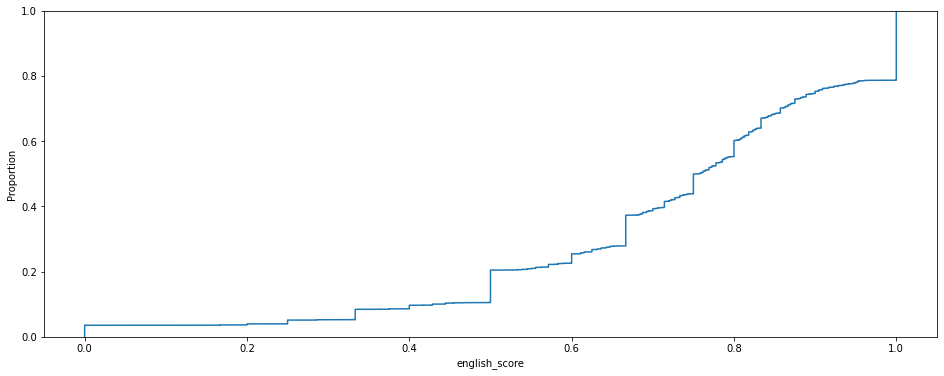

In [32]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
fig.show()

This looks neither good (sharp transistion) nor bad (very smooth transition). I'll have to explore this further

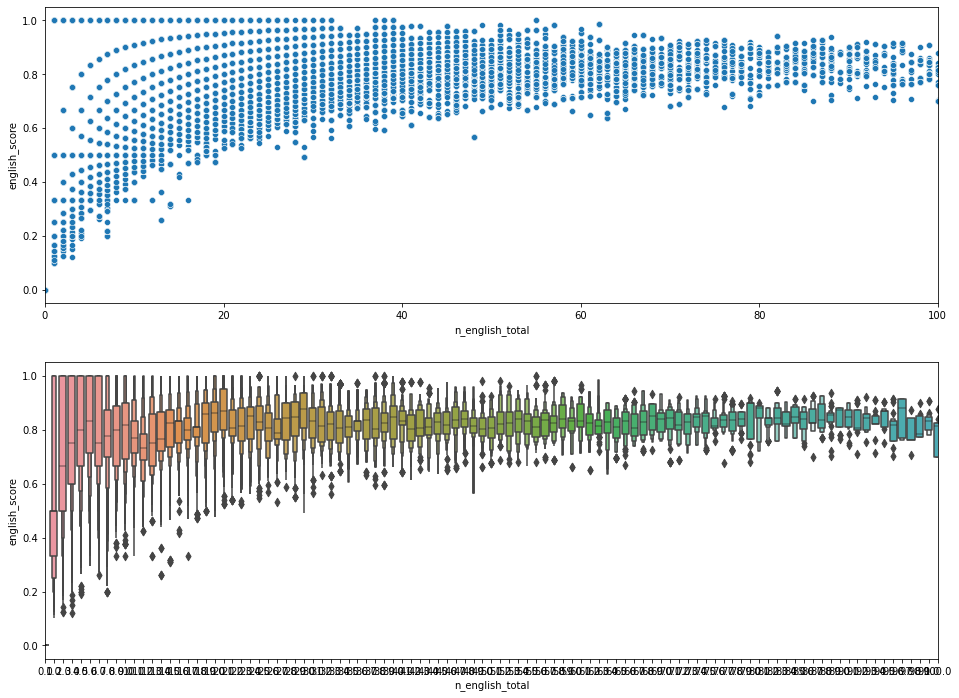

In [33]:
# plot the english score as a function of english words
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.scatterplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[0]
)
ax[0].set_xlim(0, 100)

sns.boxenplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[1]
)
ax[1].set_xlim(0, 100)

fig.show()

This looks less promising as there's a large spread in english score vs. english words. Better look at some samples to see what's going on.

In [34]:
# original text in score window
products_sample_raw_train_test_df.merge(
    products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], 
    on=primary_keys, 
    how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
6971,564301,3102,w21xxgu,Hotplate Seafood Hor Fun,None,11,test
5125,500803,61,w21z675,Malika Almonds 500g,Raw Almonds,7,train
7690,141113,7624,w21ze0w,13122097 Treats Ajitsuke Tamago 100g (Chilled),None,1,test
405,526684,623,w21z66v,Shizuoka Matcha Avocado Smoothie 静岡の抹茶牛油果冰沙,None,8,train
64,572272,2160,w21zc4w,Thai Style Beancurd 泰式豆腐,3 Pcs,12,train
6366,224991,6038,w23b632,Prawn Telur Dadar,Udang,1,train
290,575606,9,w21zetv,E1. Tamago Shoyu Ramen,"Chef's recommended, ni tamago, onsen tamago, c...",12,train
3798,525019,2990,w21zvgz,Rice + Sambar + Rasam + 2 Vegetables + Papadam,Veg meals,8,train
4922,459207,5107,w21zs0h,Korean Beancurd Soup Seafood,None,5,train
7158,480218,788,w21zu1v,Demiglace Wagyu Cheese Burger:,None,6,test


In [35]:
# original text in score window
products_sample_raw_train_test_df.merge(
    products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], 
    on=primary_keys, 
    how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
54945,26367,409,w21zvdd,Pancakes,Served with butter & maple syrup,40,train
18162,531961,3835,w21zs0h,Roasted Duck Noodle,None,8,train
67653,121724,2588,w21zv97,Yakult Apple Jelly Green Tea,Recommended. Toppings available,1,test
24703,65012,7869,w21zu6s,Set 2 组2,"Nasi lemak, luncheon meat, otah, egg & peanut...",1,train
21675,143664,11466,w21zewy,Raspberry Lychee,Sorbet made from real raspberries and lychees ...,1,train
51942,572498,400,w21z8jw,112. Teriyaki Grilled Chicken,None,12,train
15395,463545,91,w21z7zk,G5. Honey Ribs King,None,5,train
70041,140282,3202,w21z7zh,Spicy Beef Slices 水煮牛肉片,None,1,test
39273,64708,4950,w23b4rz,13072913 Heaven & Eearth Mango Green Tea 500ml,None,1,train
19514,316006,2678,w21z6dj,Hut's Platter,"Tempura prawn, sweet 'n' spicy drumlets, calam...",2,train


This is not very clear. Maybe the english score wasn't a very good idea. I'll drop back to only number of english words as a metric.

## look at original text with number of english words

Draw some samples with a given number of english words to see what's going on.

In [36]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 0 ][primary_keys], on=primary_keys, how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
20333,69977,2303,w21zc5n,Swicy,None,1,test
10978,304601,917,w23b4ve,R106. Horlicks,None,2,train
11642,367607,3899,w21ztjd,Laksa 叻沙,None,3,train
3706,353763,578,w21zgf6,Tiramisu,None,3,train
18590,300140,6137,w21z3jn,Pappadam,None,2,test
7530,115033,5593,w21zg9v,Myojo Mee Goreng | 5x79 g,None,1,train
20996,473962,10215,w21zdwx,Fishball OnStik,None,6,test
18389,199628,791,w21z7q3,Horlicks O,None,1,test
15495,528043,3396,w21zkps,Pepsi,None,8,train
21603,541824,1907,w21zetg,Tonkotsu Karaage Ramen,None,9,test


In [37]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 1][primary_keys], on=primary_keys, how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
51678,43633,1060,w21zsyp,Chicken Burger,None,55,train
21097,562851,1766,w21zgfp,Ribena Ice,None,11,train
14909,432670,35,w21zs05,732. Spaghetti Marinara,None,4,train
42246,4565,1516,w21z9j6,Maggi Goreng with Ayam,None,27,train
40565,447070,1587,w21zts2,Malai Tikka,4 Pcs,5,train
36940,343178,263,w21xxgg,Buttery Croissant,None,3,train
34805,99988,1606,w21ztdz,Couscous,None,1,train
46823,271332,8792,w21z6be,Seafood,Gravy,2,train
59040,219914,6864,w21z71w,Rendang Chicken Toastwich,None,1,test
35142,318956,4186,w21zgfp,Tea O 茶 O,None,2,train


In [38]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 2][primary_keys], on=primary_keys, how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
19350,98807,7427,w21zuk5,Breakfast Special,None,1,train
65400,168498,2374,w21zgdp,Cereal Prawn 麦片虾,None,1,train
39374,335562,6046,w21z701,YOPLAIT MIXED BERRY (5005928) | 100 g,None,3,train
83286,403041,484,w23b4u5,Gula Melaka Tea,None,4,test
64663,282682,12134,w21z8dx,Aburi Salmon Don,None,2,train
94761,146809,11906,w21zt10,Green Tea,None,1,test
82878,522218,6221,w21zdcp,52030030 Nab Ice 2.5 Kg,None,8,test
10781,74698,9286,w21z6dh,DS06. Mini Char Siew Pau 迷你叉烧包,4 Pcs 4粒,1,train
95774,24174,4501,w21z3pq,Thai Milk Tea,None,25,test
12859,266461,1306,w21z8gm,Onion Masala Dosa,None,2,train


In [39]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 3][primary_keys], on=primary_keys, how="inner").sample(20)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
77857,587171,3424,w21zbyd,Hor Fun in Gravy 什锦河粉,None,13,test
84224,551340,3565,w21zgcs,Roasted Chicken & Duck Rice 烧鸡烧鸭饭,烧鸡烧鸭饭,10,test
2431,612399,528,w21zs0j,Chee Cheong Fun and Chwee Kueh,None,17,train
1293,196931,11598,w21z6tr,The Shortcake Whole (15cm),None,1,train
7011,275206,1765,w21z4sc,Honey Lemon (Cold),None,2,train
60398,38460,115,w23b1vv,Chocolate Milk Tea,None,62,train
4518,558123,3986,w21z8dx,Tea with Milk,None,10,train
11680,33195,2795,w21xxgg,Cheese Egg Tart,1 Pc,24,train
17099,128888,6282,w21zbf8,Garbath Garbath 265002 Double Towel Bar | 800 g,None,1,train
83458,462394,1714,w21zbfu,295437 Tiger Beer Canned 320ml 6s,None,5,test


Looks like the english score is not yet good enough. I'll stick for now to "at least one english word", which is also the easiest option. This can always be improved at a later stage.

## actual filtering for english items
Apply the filter for only english items

In [40]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["n_english_total"] > 0]

In [41]:
# how much did we filter?
len(products_sample_raw_train_test_df), len(products_english_filtered_df)

(633148, 610503)

# word2vec embedding
I will throw name and description together for the word2vec embedding as I will be averaging the vectors anyway. This is not a very good idea, and doc2vec and so on are better alternatives, but for now I stick to KISS and choose the simplest approach.

I train the word2vec only on the training data but already apply it to both training and test data for ease of use. This should prevent information leaks.

## gather data
Gather filtered data and bring it into a form, which works with gensim

In [42]:
products_doc_df = (
    # start with english products
    products_english_filtered_df[primary_keys]
    # add order_count
    .merge(products_df, on=primary_keys, how="inner")
    # add tokens
    .merge(products_text_token_df, on=primary_keys, how="inner")
    # and merge stemmed tokens into list as word2vec needs it
    .groupby(doc_keys)["text_tokens_stemmed"]
    .agg(list)
    .reset_index())

## train embedding

I will ignore hyperparameter tuning of Word2Vec for now. But I'm using CBOW, mainly for speed.

I'm only training the embeddin on training data obviously.

In [43]:
# train word2vec embedding on training data
w2v_model = gensim.models.Word2Vec(products_doc_df[products_doc_df["split"] == "train"]["text_tokens_stemmed"], sg=0, size=30)

## look at the embedding with t-sne

In [44]:
# calculate tsne for embedding

# get data
vectors = np.asarray(w2v_model.wv.vectors)

# first reduce dimensionality with pca
#pca = sklearn.decomposition.PCA(n_components=20)
#vectors_pca = pca.fit_transform(vectors)

# for testing: sample some vectors
#v_idx = np.random.randint(vectors_pca.shape[0], size=1000)
#vectors_pca = vectors_pca[v_idx,:]

# then calculcate tsne
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
vectors_tsne = tsne.fit_transform(vectors)

# then add labels for plotting
vectors_df = pd.DataFrame(vectors_tsne, columns=["x", "y"])
vectors_df["label"] = np.asarray(w2v_model.wv.index2entity)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 11896 samples in 0.043s...
[t-SNE] Computed neighbors for 11896 samples in 10.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11896
[t-SNE] Computed conditional probabilities for sample 2000 / 11896
[t-SNE] Computed conditional probabilities for sample 3000 / 11896
[t-SNE] Computed conditional probabilities for sample 4000 / 11896
[t-SNE] Computed conditional probabilities for sample 5000 / 11896
[t-SNE] Computed conditional probabilities for sample 6000 / 11896
[t-SNE] Computed conditional probabilities for sample 7000 / 11896
[t-SNE] Computed conditional probabilities for sample 8000 / 11896
[t-SNE] Computed conditional probabilities for sample 9000 / 11896
[t-SNE] Computed conditional probabilities for sample 10000 / 11896
[t-SNE] Computed conditional probabilities for sample 11000 / 11896
[t-SNE] Computed conditional probabilities for sample 11896 / 11896
[t-SNE] Mean sigma: 0.245108
[t-SNE] KL divergenc

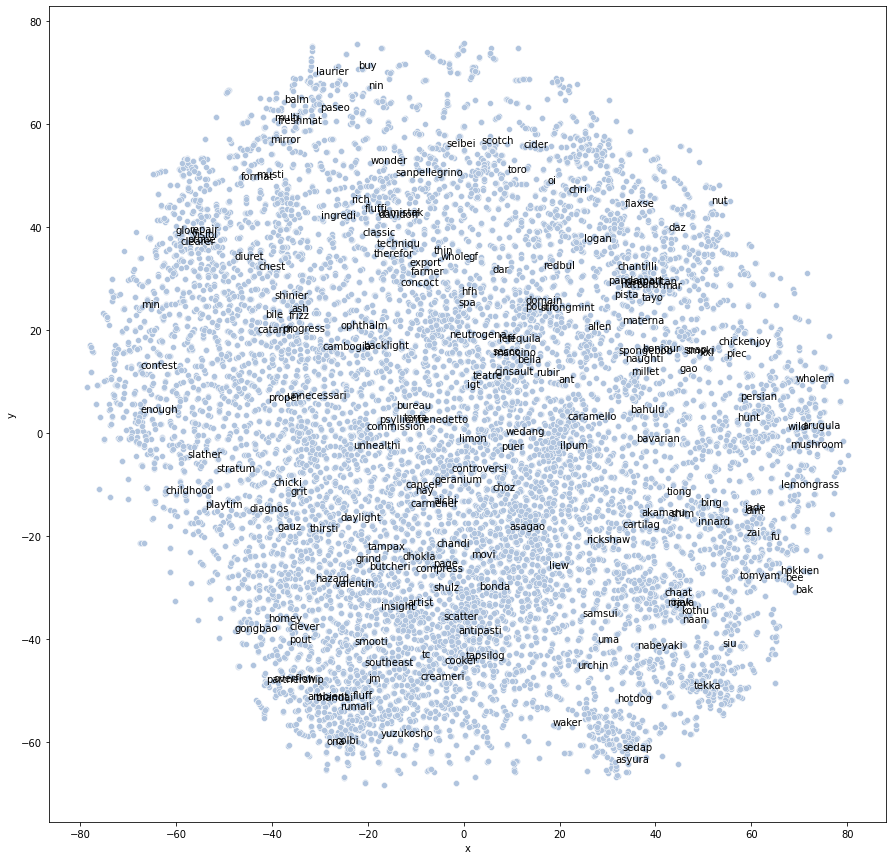

In [45]:
# visualize tsne
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    ax=ax,
    color="lightsteelblue"
)
for index, row in vectors_df.sample(200).iterrows():
  plt.annotate(
      s=row["label"],
      xy=(row["x"], row["y"]),
      color="black"
  )
fig.show()

Some clustering seems to be there, but I'm not a huge fan of t-SNE as it easily leads to false assumptions. However, it looks good.

## calculate the data embedding for learning

I'm doing this on train and test simulataneously.

Instead of using for exmaple doc2vec, I'm using the quickest and easiest thing I know to translate name and decription into a single vector: I just average all vectors. This is a bad idea for a lot of reasons:

* losing a lot of information from the order of words
* losing a lot of inromation from the words themselves
* long names and descriptions are being "watered down"
* there is no good theoretical foundation to do this
* etc.

However, for simplicity, I'm going to stick with it.

In [46]:
def embed_tokens(tokens, model):
  dims = model.wv["foo"].shape[0]
  vec = np.zeros(dims)
  if type(tokens) is list and len(tokens) > 0:
    vecs = [model.wv[token] for token in tokens if token in model.wv.vocab.keys()]
    if len(vecs) > 0:
      vec = vec + np.mean(vecs, axis=0)
  return vec

In [47]:
products_doc_df["text_vec"] = products_doc_df["text_tokens_stemmed"].apply(lambda x: embed_tokens(x, w2v_model))

In [48]:
products_doc_df

,product_id,vendor_id,vendor_geohash,split,order_count,text_tokens_stemmed,text_vec
0,0,0,w21z6tu,test,116,"[chees, tofu]","[1.8889871835708618, 1.725719928741455, -0.976..."
1,1,1,w21z74d,train,30,"[naughti, nice, slice, chocol, slice]","[-0.216961070895195, 1.7697231769561768, -0.25..."
2,2,2,w21xxgu,train,25,"[pork, dumpl, with, hot, chilli, vinaigrett, p...","[1.8722158670425415, 1.243099331855774, 0.0798..."
3,3,3,w23b4u1,train,45,"[mee, kuah, contain, minc, mutton, meat]","[-0.43986213207244873, 0.8564659953117371, 0.3..."
4,4,4,w21ztq4,train,24,"[ham, chees, sandwich, set, toast, to, perfect...","[1.1266285181045532, 0.9913471341133118, 0.517..."
...,...,...,...,...,...,...,...
610498,633143,701,w21zkpm,train,22,"[sriracha, chicken, whole, wheat, pita]","[1.3309465646743774, -0.7308520078659058, -0.5..."
610499,633144,17,w23b5j9,test,22,"[dettol, liquid, hand, wash, sensit, ml, detto...","[-0.8993223309516907, -1.9568873643875122, -0...."
610500,633145,4135,w21ztw0,test,22,"[red, bean, pcs]","[0.7032607197761536, 3.832228422164917, -1.029..."
610501,633146,3121,w21z6vc,test,22,"[twister, meal, choic, of, twister, hash, brow...","[0.6000430583953857, 2.5708773136138916, 1.371..."


## look at the order_count on the embedding of a data sample with t-sne

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 7.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.747696
[t-SNE] KL divergence after 1000 iterations: 1.502730


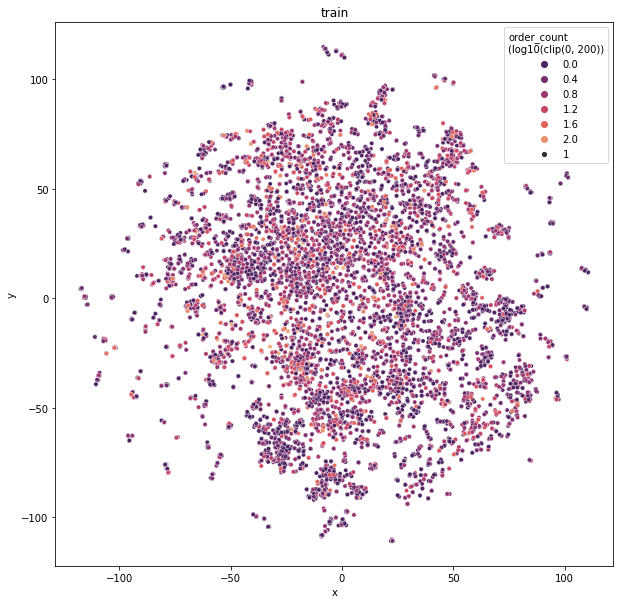

In [49]:
# look at the doc embeddings for training data
# if you look at the test data, you will become biased, so don't peek
products_doc_plot_df = products_doc_df[products_doc_df["split"] == "train"].sample(10000)

# tsne with same parameters as above
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
vectors = tsne.fit_transform(np.vstack(products_doc_plot_df["text_vec"].to_numpy()))

vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
# clipping and log-scale order-count for plotting
# take care: we dropped the index, so we can't just re-join old data
vectors_df["order_count"] = products_doc_plot_df["order_count"].apply(lambda x: np.log10(np.clip(x, 0, 200))).tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    size=1,
    hue="order_count",
    palette="flare_r",
    ax=ax
)
ax.set_title("train")
ax.legend(title="order_count\n(log10(clip(0, 200))")
fig.show()

I don't really see anything on this plot and hyperparameter tuning for t-SNE didn't help much. This doesn't necessarily mean that the embedding is bad or good as we are dealing with the embedding of the embedding.

# Regression

I'm not using pre-built sklearn metrics during exploration because I want to be able to look at error distributions and so on.

I'm going to compare all models to an mean-baseline.

## prepare data for learning

In [50]:
x_train = np.vstack(products_doc_df[products_doc_df["split"] == "train"]["text_vec"])
x_test = np.vstack(products_doc_df[products_doc_df["split"] == "test"]["text_vec"])
y_train = products_doc_df[products_doc_df["split"] == "train"]["order_count"].to_numpy()
y_test = products_doc_df[products_doc_df["split"] == "test"]["order_count"].to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((488552, 30), (488552,), (121951, 30), (121951,))

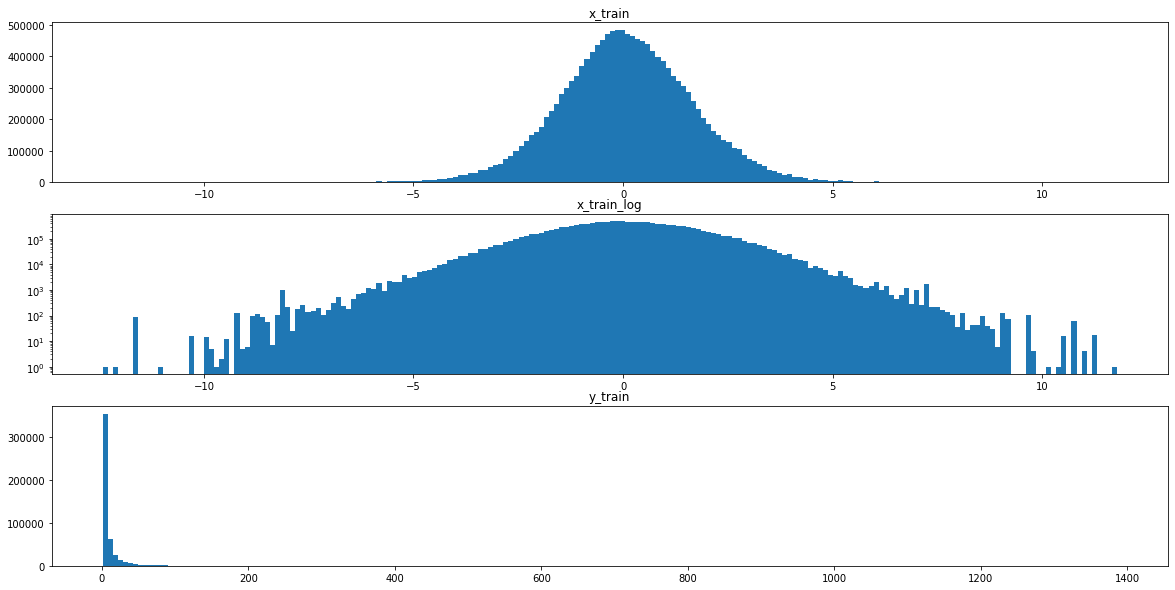

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

ax[0].hist(x_train.flatten(), bins=200)
ax[0].set_title("x_train")

ax[1].hist(x_train.flatten(), bins=200)
ax[1].set_yscale("log")
ax[1].set_title("x_train_log")

ax[2].hist(y_train.flatten(), bins=200)
ax[2].set_title("y_train")

fig.show()

## basic learning setup helpers

* A minimal dummy sklearn interface mean-baseline model
* result plotting helper
* train a model on original data
* train a model on `log10(clip(0, 200, y))` data

In [52]:
class mean_baseline:
  def __init__(self):
    self.pred = 0.0
  def fit(self, x_train, y_train):
    self.pred = np.mean(y_train)
  def predict(self, x_test):
    y_pred = np.full(x_test.shape[0], self.pred)
    return y_pred

def plot_res(title, res, mae, res_baseline, mae_baseline):
  fig, ax = plt.subplots(1, 1, figsize=(20, 5))
  ax.hist(
      res_baseline, 
      bins=400, 
      range=(
          np.min([np.min(res), np.min(res_baseline)]), 
          np.max([np.quantile(res, 0.99), np.quantile(res_baseline, .099)])),
      histtype="step", 
      label="avg baseline: {:.2f}".format(mae_baseline))
  ax.hist(
      res, 
      bins=400,
      range=(
          np.min([np.min(res), np.min(res_baseline)]), 
          np.max([np.quantile(res, 0.99), np.quantile(res_baseline, .099)])),
      histtype="step", 
      label="model: {:.2f}".format(mae))
  ax.set_title(title)
  ax.set_xlabel("residual")
  ax.legend(title="model: mae")
  fig.show()


def eval_model(model, x_train, y_train, x_test, y_test):
  baseline = mean_baseline()
  baseline.fit(x_train, y_train)
  y_pred_baseline = baseline.predict(x_test)
  res_baseline = y_test-y_pred_baseline
  mae_baseline = np.mean(np.abs(res_baseline))
  
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  res = y_test-y_pred
  mae = np.mean(np.abs(res))

  plot_res("regular", res, mae, res_baseline, mae_baseline)

def eval_model_clipped_log(model, x_train, y_train, x_test, y_test):
  y_train_log = np.log10(np.clip(y_train, 0, 200))

  baseline = mean_baseline()
  baseline.fit(x_train, y_train_log)
  y_pred_log_baseline = baseline.predict(x_test)
  y_pred_baseline = np.power(10, y_pred_log_baseline)
  res_baseline = y_test-y_pred_baseline
  mae_baseline = np.mean(np.abs(res_baseline))

  model.fit(x_train, y_train_log)
  y_pred_log = model.predict(x_test)
  y_pred = np.power(10, y_pred_log)
  res = y_test-y_pred
  mae = np.mean(np.abs(res))

  plot_res("clipped-log", res, mae, res_baseline, mae_baseline)

## models

### baseline: linear model

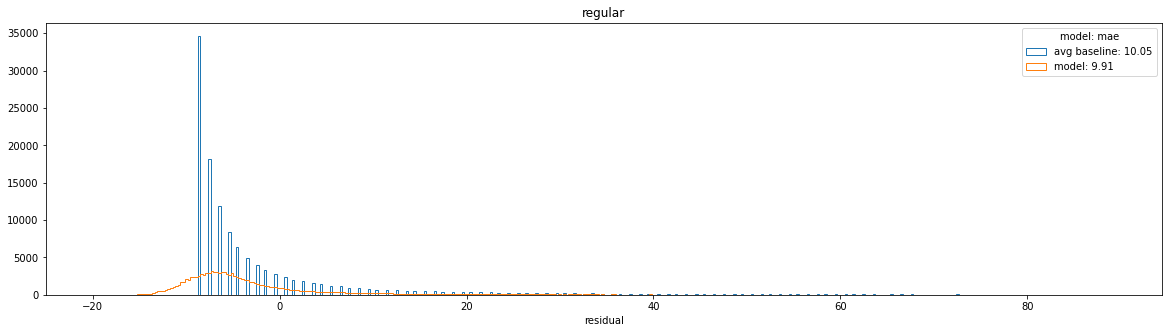

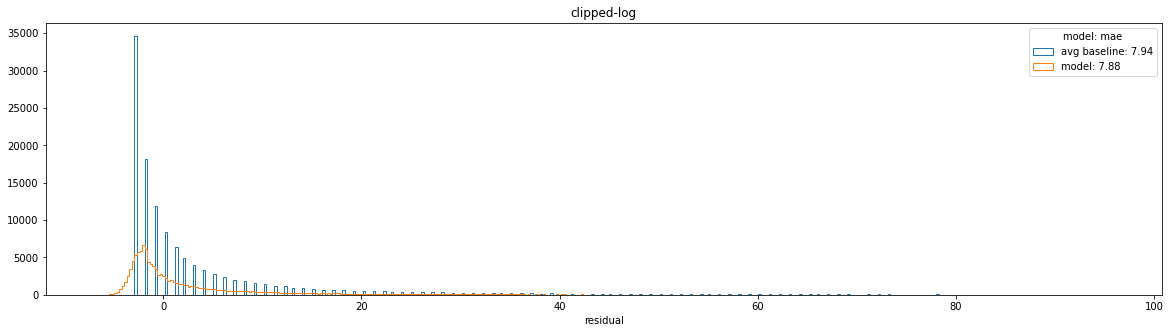

In [53]:
lin_model = sklearn.linear_model.LinearRegression()
eval_model(lin_model, x_train, y_train, x_test, y_test)
eval_model_clipped_log(lin_model, x_train, y_train, x_test, y_test)

The log_clip trick clearly helps the basic linear model.

### baseline: ElasicNetCV

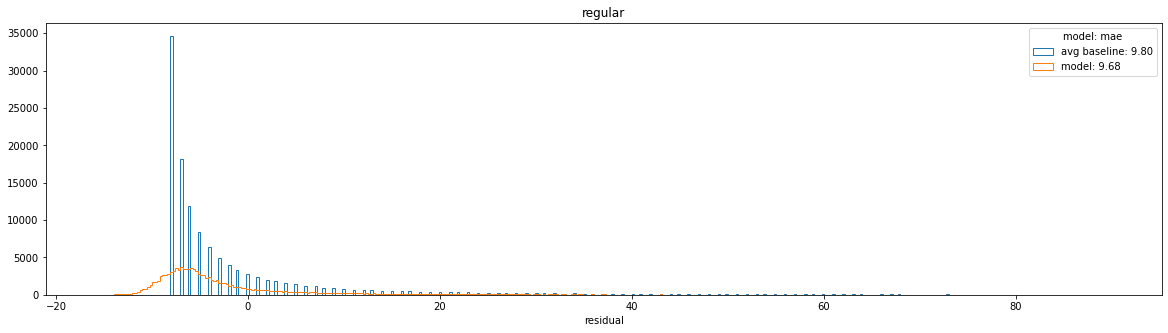

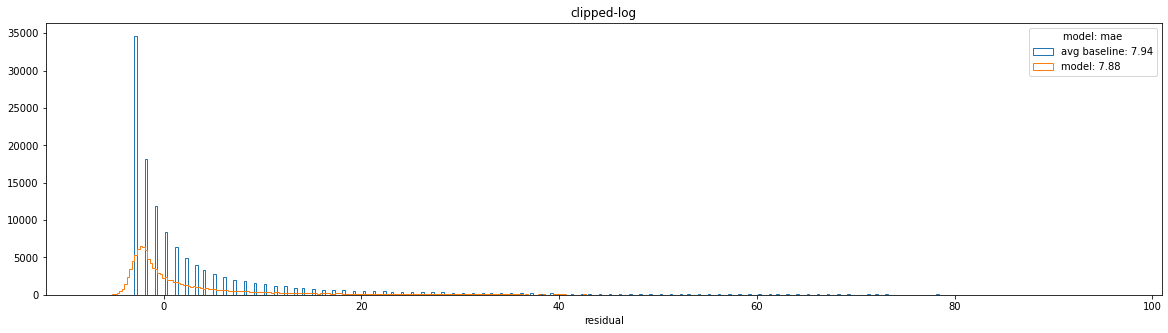

In [54]:
elastic_model = sklearn.linear_model.ElasticNetCV()

# sampling for speed in experimentation
idx_sample = np.random.randint(x_train.shape[0], size=10000)
x_train_sample = x_train[idx_sample,:]
y_train_sample = y_train[idx_sample]

eval_model(elastic_model, x_train_sample, y_train_sample, x_test, y_test)
eval_model_clipped_log(elastic_model, x_train_sample, y_train_sample, x_test, y_test)

### RandomForestRegressor

In [55]:
# this takes too long
if False:
  rf_model = sklearn.ensemble.RandomForestRegressor()

  # sampling for speed in experimentation
  idx_sample = np.random.randint(x_train.shape[0], size=10000)
  x_train_sample = x_train[idx_sample,:]
  y_train_sample = y_train[idx_sample]

  eval_model(rf_model, x_train_sample, y_train_sample, x_test, y_test)
  eval_model_clipped_log(rf_model, x_train_sample, y_train_sample, x_test, y_test)

### HistGradientBoostingRegressor
Because I have good experience with it and I don't have to deal with XGBoost etc.

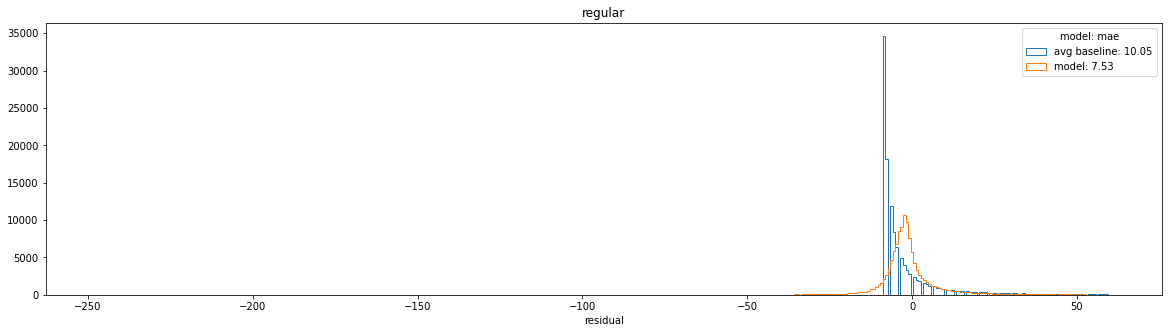

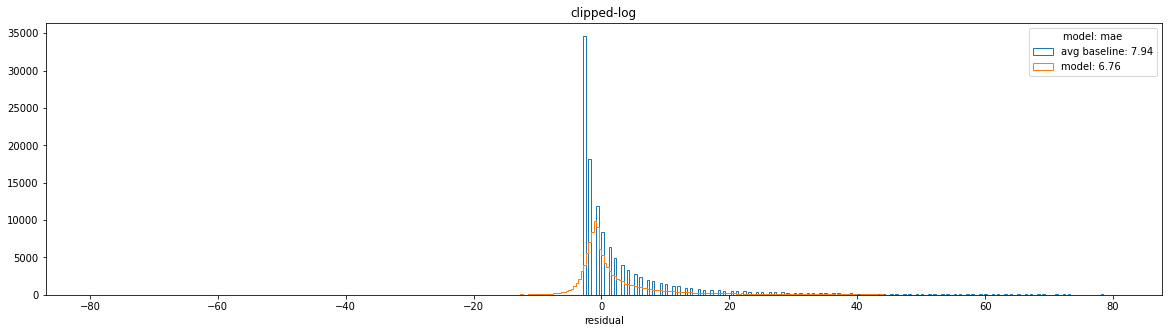

In [56]:
hgb_model = sklearn.ensemble.HistGradientBoostingRegressor(max_iter=500, max_leaf_nodes=65)
eval_model(hgb_model, x_train, y_train, x_test, y_test)
eval_model_clipped_log(hgb_model, x_train, y_train, x_test, y_test)

## sanity check: can we overfit a small subsample?

Check if we can overfit a small test sample, i.e., check against train.

In [57]:
# sample from data
sample_idx = np.random.randint(x_train.shape[0], size=1000)
sample_xtrain = x_train[sample_idx]
sample_ytrain = y_train[sample_idx]

sample_xtrain.shape, sample_ytrain.shape

((1000, 30), (1000,))

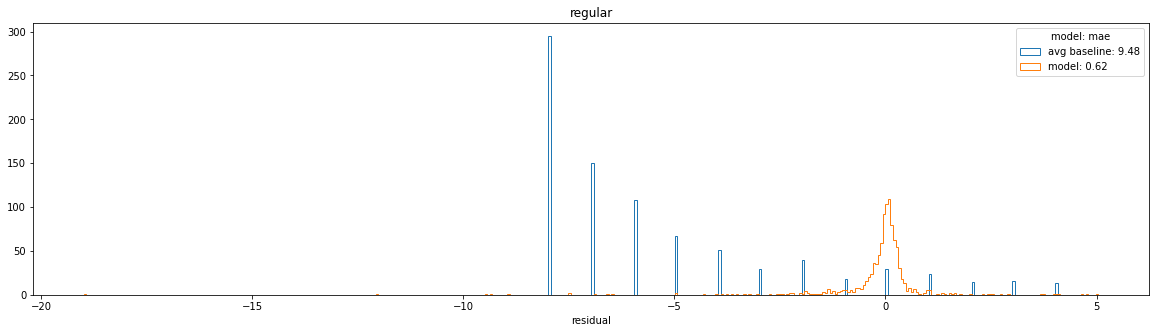

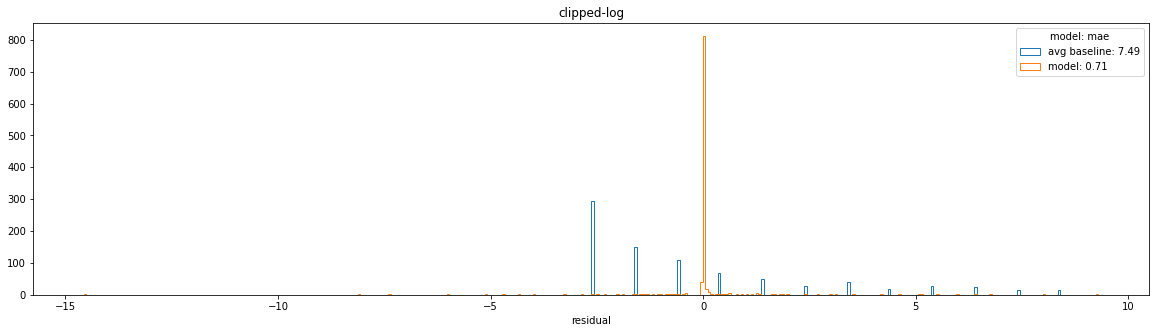

In [58]:
# see if we can overfit this
hgb_model = sklearn.ensemble.HistGradientBoostingRegressor(max_iter=500)

eval_model(hgb_model, sample_xtrain, sample_ytrain, sample_xtrain, sample_ytrain)
eval_model_clipped_log(hgb_model, sample_xtrain, sample_ytrain, sample_xtrain, sample_ytrain)

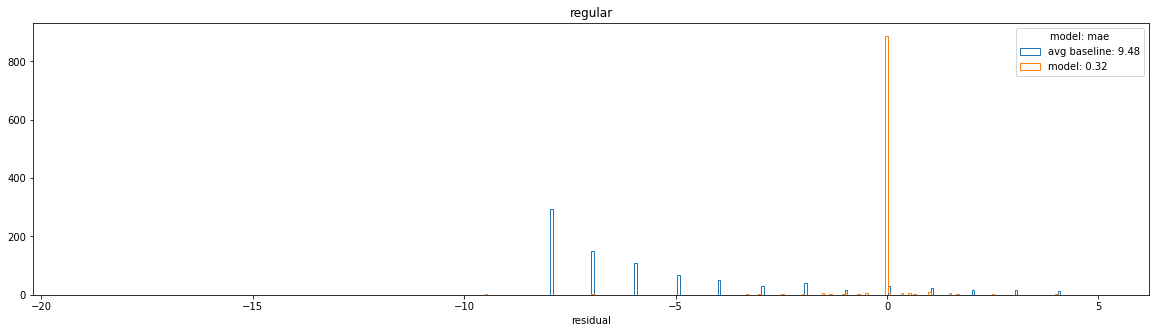

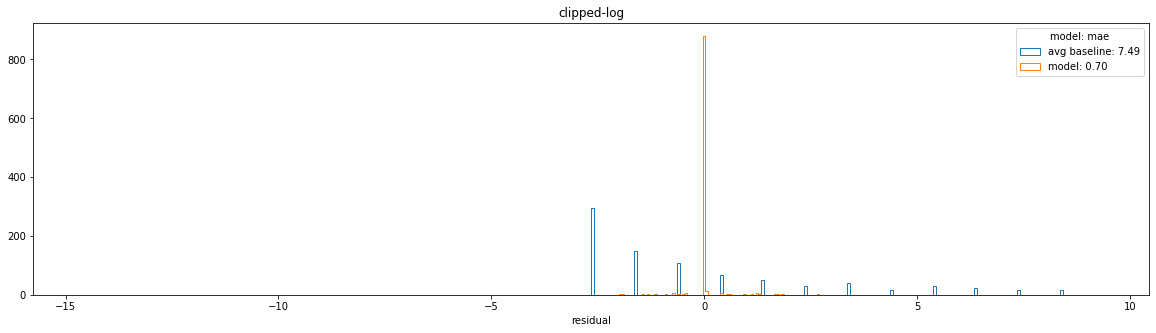

In [59]:
# see if we can overfit this
hgb_model = sklearn.ensemble.HistGradientBoostingRegressor(max_iter=500, min_samples_leaf=5)

eval_model(hgb_model, sample_xtrain, sample_ytrain, sample_xtrain, sample_ytrain)
eval_model_clipped_log(hgb_model, sample_xtrain, sample_ytrain, sample_xtrain, sample_ytrain)

Yay, we can overfit this.

# Summary

## cleanup verdict
Obviously I could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

## Regression Verdict and possible improvements
I got nothing much better than mean-baseline. However, the models seem to be learning something and the clip+log trick seems to be working well. There are tons of things to improve:
* embedding
  * hyperparameter tuning
  * glove or something like that instead of word2vec
  * doc2vec instead of averaging word vectors (which is expected to not work very well)
* regression
  * hyperparameter tuning
  * try out XGBoost/Catboost (I wouldn't expect it to be much better)
* different approach
  * try out AutoGluon (text mode) to see what it comes up with
  * trying to use a GRU or (pretrained) transformer to learn the regression and embedding in one step
  * classification of hit/flop instead of regression on order_count 
* coding
  * there is still quite a bit of copy pasted code, which could be put into functions, especially for plotting stuff
  * ther is still quite a bit of variable reuse

## general ideas

* I think a better preprocessing could help quite a bit
 * culinary terms
 * measurement units
 * names of food-chain items
* probably the worst step here is averaging the word2vec vectors for all text
  * doc2vec would be better
  * sentenceBERT could also be tried
  * or have a deep model learn the whole thing in one go
* hyperparameter tuning has been left out completely
* I wouldn't just throw AutoGluon(text) at it, as it's not super transparent